In [94]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp

Using a Lagrangian Orbit class I generate orbit plots for a 2 body problem using Lagrange's equations

Last revised 28-April-2023 by Tayt Armitage (armitage.44@buckeyemail.osu.edu)

# This notebook models a 2 Body problem in cartesian coordinates, utilizing lagrange's equations for gravitation

Kinetic Energy is given by 

$T = \frac{1}{2} m_1 \dot{x}_1^2 + \frac{1}{2} m_1 \dot{y}_1^2 + \frac{1}{2} m_2 \dot{x}_2^2 + \frac{1}{2} m_2 \dot{y}_2^2$

The potential energy is then given by

$U = \frac{G m_1 m_2}{\sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2}}$

The Lagrangian is then given by L = T - U

$L = \frac{1}{2} m_1 \dot{x}_1^2 + \frac{1}{2} m_1 \dot{y}_1^2 + \frac{1}{2} m_2 \dot{x}_2^2 + \frac{1}{2} m_2 \dot{y}_2^2 -\frac{G m_1 m_2}{\sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2}}$

# Euler-Lagrange Equations

$\frac{d}{dt} \frac{dL}{d \dot{x_1}} - \frac{dL}{dx_1} = m_1 \ddot{x_1}$
$- \frac{G m_1 m_2 (x_1-x2)}{((x_1 - x_2)^2 + (y_1 - y_2)^2) ^\frac{3}{2}} = 0$


$\frac{d}{dt} \frac{dL}{d \dot{x_2}} - \frac{dL}{dx_2} = m_2 \ddot{x_2}$
$+ \frac{G m_1 m_2 (x_1-x_2)}{((x_1 - x_2)^2 + (y_1 - y_2)^2) ^\frac{3}{2}} = 0$

$\frac{d}{dt} \frac{dL}{d \dot{y_1}} - \frac{dL}{dy_1} = m_1 \ddot{y_1}$
$- \frac{G m_1 m_2 (y_1-y_2)}{((x_1 - x_2)^2 + (y_1 - y_2)^2) ^\frac{3}{2}} = 0$

$\frac{d}{dt} \frac{dL}{d \dot{y_2}} - \frac{dL}{dy_2} = m_2 \ddot{y_2}$
$+ \frac{G m_1 m_2 (y_1-y_2)}{((x_1 - x_2)^2 + (y_1 - y_2)^2) ^\frac{3}{2}} = 0$

These equations will then serve as the basis for the following code to predict the orbiits

## 2a. Model the 2 body problem using cartesian coordinatesr## 2a. Model the 2 body problem using cartesian coordinates.

Down below are three plots that show different orbits modeled using these equations, that had been set up in such a way that the center of mass does not move. Two orbits shown are circular orbits, while the other is a highly eclipse orbit. But it can be seen that both objects orbit around their common center of mass. 

## 2b. In the instance of an increasing mass of one of the bodies the orbit essentially becomes a two body problem once more. There are 5 plots that detail the orbit of two bodies, with the larger one moving slowly and near the origin. As its mass grows larger, its motion about the origin decreases until it can be treated as approximately stationary. Thus showing that when the difference between the masses is great, the two body problem can be modeled as one body in a potential well 

# 2.4(final cells)

### So the leapfrog function is not too precise I likely made an error somewhere in my code for it. However it is conserving energy by periodically resetting back to a difference of zero. In this case right now the RK45 model is more precise, but it is rising in energy and thus is not conserving energy. Therefore after a substaintial amount of time it will eventually be overtaken in accuracy by the leapfrog model.

In [529]:
class Cartesian_Orbit():
    '''
    This class simulates the orbital dynamics of two bodies. It utilizes the Lagrange's equations
    on gravitational attraction in cartesian coordinate representation.
    ----------
    Parameters
    -----------
    m1: float
    m2: float
    G: float
    ---------
    df/dt(t,f):
    Returns the right side of the differential equation in f, with respect to time t
    '''
    def __init__(self,m1=1.,m2=1.,G=1.):
        self.m1 = m1
        self.m2 = m2
        self.G = G
    
    def df_dt(self,t,f):
        """
        This returns the right side of df/dt
        
        [df/dt d^2f/dt^2]
        
        t: float
        f: a 8 component vector storing information on the position and speed of both particles
        
        f[0] = x_1     f[1] = x_1_dot
        f[2] = y_1     f[3] = y_1_dot
        f[4] = x_2     f[5] = x_2_dot
        f[6] = y_2     f[7] = y_2_dot
         
        """
        
        distance = np.sqrt( (f[0]-f[4])**2 + (f[2]-f[6])**2)
        
        return[f[1], self.G * self.m2 * (f[4]-f[0])/ distance**3,\
               f[3], self.G * self.m2 * (f[6]-f[2])/ distance**3,\
               f[5], -self.G * self.m1 * (f[4]-f[0])/ distance**3,\
               f[7], -self.G * self.m1 * (f[6]-f[2])/ distance**3\
                ]
    def solve_ode(self, t_pts, f_0,
                  method='RK45',
                  abserr=1.0e-8, relerr=1.0e-8):
        """
        Solve the ODE given initial conditions.
        Use solve_ivp with the option of specifying the method.
        Specify smaller abserr and relerr to get more precision.
        """
        solution = solve_ivp(self.df_dt, (t_pts[0], t_pts[-1]), 
                             f_0, t_eval=t_pts, method=method, 
                             atol=abserr, rtol=relerr)
        x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot = solution.y
        return x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot
    
    def solve_ode_Leapfrog(self, t_pts, f_0):
        """
        Solve the ODE given initial conditions with the Leapfrog method.
        """
        delta_t = t_pts[1] - t_pts[0]
        
        x1_0, x1_dot_0, y1_0, y1_dot_0, x2_0, x2_dot_0, y2_0, y2_dot_0 = f_0
        
        
        # initialize 
        num_t_pts = len(t_pts)
        
        x1 = np.zeros(num_t_pts)
        x1_dot = np.zeros(num_t_pts)
        x1_dot_half = np.zeros(num_t_pts)
        
        x2 = np.zeros(num_t_pts)
        x2_dot = np.zeros(num_t_pts)
        x2_dot_half = np.zeros(num_t_pts)
        
        y1 = np.zeros(num_t_pts)
        y1_dot = np.zeros(num_t_pts)
        y1_dot_half = np.zeros(num_t_pts)
        
        y2 = np.zeros(num_t_pts)
        y2_dot = np.zeros(num_t_pts)
        y2_dot_half = np.zeros(num_t_pts)
        
        # initial conditions
        x1[0] = x1_0
        x1_dot[0] = x1_dot_0
        x2[0] = x2_0
        x2_dot[0] = x2_dot_0
        y1[0] = y1_0
        y1_dot[0] = y1_dot_0
        y2[0] = y2_0
        y2_dot[0] = y2_dot_0

        
        # step through the differential equation
        for i in np.arange(num_t_pts - 1):
            t = t_pts[i]
            f = [x1[i], x1_dot[i], y1[i], y1_dot[i], x2[i], x2_dot[i], y2[i], y2_dot[i]]
            
            derivatives = self.df_dt(t,f)
            
            x1_dot_half[i] = x1_dot[i] + derivatives[1] * delta_t/2
            x1[i+1] = x1[i] + x1_dot_half[i] * delta_t
            
            y1_dot_half[i] = y1_dot[i] + derivatives[3] * delta_t/2
            y1[i+1] = y1[i] + y1_dot_half[i] * delta_t
            
            x2_dot_half[i] = x2_dot[i] + derivatives[5] * delta_t/2
            x2[i + 1] = x2[i] + x2_dot_half[i] * delta_t
            
            y2_dot_half[i] = y2_dot[i] + derivatives[7] * delta_t/2
            y2[i + 1] = y2[i] + y2_dot_half[i] * delta_t
            
            f = [x1[i+1], x1_dot[i], y1[i+1], y1_dot[i], x2[i+1], x2_dot[i], y2[i+1], y2_dot[i]]
            
            derivatives = self.df_dt(t,f)
            
            x1_dot[i+1] = x1_dot_half[i] + derivatives[1] *delta_t/2
            y1_dot[i+1] = y1_dot_half[i] + derivatives[3] *delta_t/2
            x2_dot[i+1] = x2_dot_half[i] + derivatives[5] *delta_t/2
            y2_dot[i+1] = y2_dot_half[i] + derivatives[7] *delta_t/2
            
        return x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot
    
    def energy(self, t_pts, x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot):
        """Evaluate the energy as a function of time"""
        return .5 * self.m1 * x1_dot**2 + .5 * self.m1 * y1_dot**2 + .5 * self.m2 * x2_dot**2 + .5 * self.m2 * y2_dot**2 - (self.G * self.m1*self.m2)/np.sqrt((x1-x2)**2 + (y1-y2)**2)

In [481]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

In [482]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

In [483]:
t_start = 0.
t_end = 30.
delta_t = 0.001


t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

G = 1.
m2 = 5.
m1 = 1.

In [484]:
orbit1 = Cartesian_Orbit(m1,m2,G)
x1_0, x1_dot_0 =1,-1.
y1_0, y1_dot_0 = 1.,1.
x2_0, x2_dot_0 = -(m1/m2) * x1_0,-(m1/m2) * x1_dot_0
y2_0, y2_dot_0 = -(m1/m2) * y1_0, -(m1/m2) * y1_dot_0

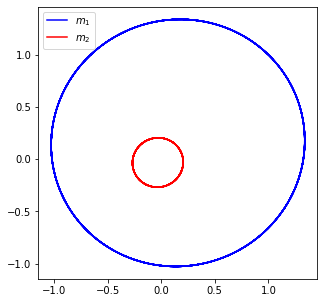

In [485]:
f_0 = [x1_0, x1_dot_0, y1_0, y1_dot_0, x2_0, x2_dot_0, y2_0, y2_dot_0]
x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot = orbit1.solve_ode(t_pts,f_0)


fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
start,stop = start_stop_indices(t_pts,t_start,t_end)
ax.plot(x1, y1,color = 'blue', label = r'$m_1$')
ax.plot(x2, y2, color = 'red', label = r'$m_2$')
ax.set_label('Gravitational Orbit 1')
ax.legend()

# Now to try out a few more of the orbits

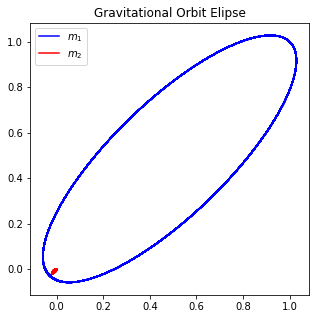

In [486]:
G = 1.
m2 = 50.
m1 = 1.


orbit1 = Cartesian_Orbit(m1,m2,G)
x1_0, x1_dot_0 =1,-1.
y1_0, y1_dot_0 = 1.,1.
x2_0, x2_dot_0 = -(m1/m2) * x1_0,-(m1/m2) * x1_dot_0
y2_0, y2_dot_0 = -(m1/m2) * y1_0, -(m1/m2) * y1_dot_0

f_0 = [x1_0, x1_dot_0, y1_0, y1_dot_0, x2_0, x2_dot_0, y2_0, y2_dot_0]
x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot = orbit1.solve_ode(t_pts,f_0)


fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
start,stop = start_stop_indices(t_pts,t_start,t_end)
ax.plot(x1, y1,color = 'blue', label = r'$m_1$')
ax.plot(x2, y2, color = 'red', label = r'$m_2$')
ax.set_title('Gravitational Orbit Elipse')
ax.legend()

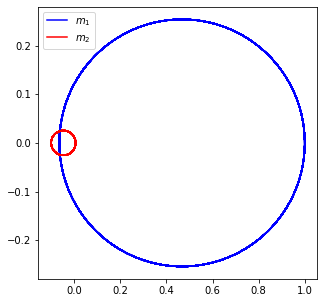

In [487]:
G = 1.
m2 = 10.
m1 = 1.


orbit1 = Cartesian_Orbit(m1,m2,G)
x1_0, x1_dot_0 =1,0.
y1_0, y1_dot_0 = 0.,1.
x2_0, x2_dot_0 = -(m1/m2) * x1_0,-(m1/m2) * x1_dot_0
y2_0, y2_dot_0 = -(m1/m2) * y1_0, -(m1/m2) * y1_dot_0

f_0 = [x1_0, x1_dot_0, y1_0, y1_dot_0, x2_0, x2_dot_0, y2_0, y2_dot_0]
x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot = orbit1.solve_ode(t_pts,f_0)


fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
start,stop = start_stop_indices(t_pts,t_start,t_end)
ax.plot(x1, y1,color = 'blue', label = r'$m_1$')
ax.plot(x2, y2, color = 'red', label = r'$m_2$')
ax.set_label('Gravitational Orbit 3')
ax.legend()

# Part B, making the central mass larger to show that it reduces to a 1 body problem

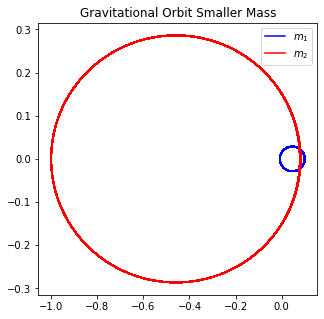

In [488]:
G = 20.
m1 = 10.
m2 = 1.


orbit1 = Cartesian_Orbit(m1,m2,G)
x1_0, x1_dot_0 =0.1, 0.
y1_0, y1_dot_0 = 0., 0.5
x2_0, x2_dot_0 = -(m1/m2) * x1_0,-(m1/m2) * x1_dot_0
y2_0, y2_dot_0 = -(m1/m2) * y1_0, -(m1/m2) * y1_dot_0

f_0 = [x1_0, x1_dot_0, y1_0, y1_dot_0, x2_0, x2_dot_0, y2_0, y2_dot_0]
x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot = orbit1.solve_ode(t_pts,f_0)


fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
start,stop = start_stop_indices(t_pts,t_start,t_end)
ax.plot(x1, y1, color = 'blue', label = r'$m_1$')
ax.plot(x2, y2, color = 'red', label = r'$m_2$')
ax.set_title('Gravitational Orbit Smaller Mass')
ax.legend()

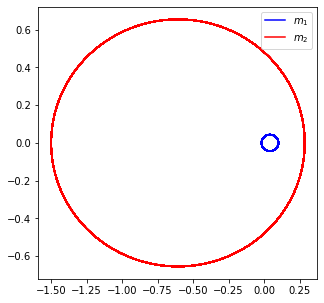

In [489]:
G = 20.
m1 = 15.
m2 = 1.


orbit1 = Cartesian_Orbit(m1,m2,G)
x1_0, x1_dot_0 =0.1, 0.
y1_0, y1_dot_0 = 0., 0.5
x2_0, x2_dot_0 = -(m1/m2) * x1_0,-(m1/m2) * x1_dot_0
y2_0, y2_dot_0 = -(m1/m2) * y1_0, -(m1/m2) * y1_dot_0

f_0 = [x1_0, x1_dot_0, y1_0, y1_dot_0, x2_0, x2_dot_0, y2_0, y2_dot_0]
x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot = orbit1.solve_ode(t_pts,f_0)


fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
start,stop = start_stop_indices(t_pts,t_start,t_end)
ax.plot(x1, y1, color = 'blue', label = r'$m_1$')
ax.plot(x2, y2, color = 'red', label = r'$m_2$')
ax.set_label('Gravitational Orbit Larger Mass')
ax.legend()

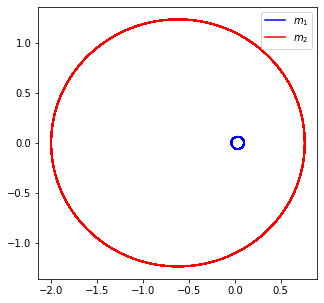

In [490]:
G = 20.
m1 = 20.
m2 = 1.


orbit1 = Cartesian_Orbit(m1,m2,G)
x1_0, x1_dot_0 =0.1, 0.
y1_0, y1_dot_0 = 0., 0.5
x2_0, x2_dot_0 = -(m1/m2) * x1_0,-(m1/m2) * x1_dot_0
y2_0, y2_dot_0 = -(m1/m2) * y1_0, -(m1/m2) * y1_dot_0

f_0 = [x1_0, x1_dot_0, y1_0, y1_dot_0, x2_0, x2_dot_0, y2_0, y2_dot_0]
x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot = orbit1.solve_ode(t_pts,f_0)


fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
start,stop = start_stop_indices(t_pts,t_start,t_end)
ax.plot(x1, y1, color = 'blue', label = r'$m_1$')
ax.plot(x2, y2, color = 'red', label = r'$m_2$')
ax.set_label('Gravitational Orbit3')
ax.legend()

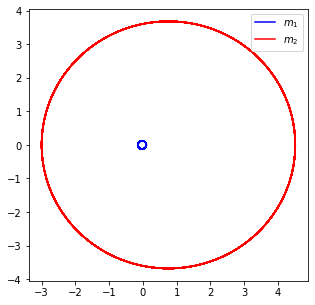

In [491]:
G = 20.
m1 = 30.
m2 = 1.


orbit1 = Cartesian_Orbit(m1,m2,G)
x1_0, x1_dot_0 =0.1, 0.
y1_0, y1_dot_0 = 0., 0.5
x2_0, x2_dot_0 = -(m1/m2) * x1_0,-(m1/m2) * x1_dot_0
y2_0, y2_dot_0 = -(m1/m2) * y1_0, -(m1/m2) * y1_dot_0

f_0 = [x1_0, x1_dot_0, y1_0, y1_dot_0, x2_0, x2_dot_0, y2_0, y2_dot_0]
x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot = orbit1.solve_ode(t_pts,f_0)


fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
start,stop = start_stop_indices(t_pts,t_start,t_end)
ax.plot(x1, y1, color = 'blue', label = r'$m_1$')
ax.plot(x2, y2, color = 'red', label = r'$m_2$')
ax.set_label('Gravitational Orbit3')
ax.legend()

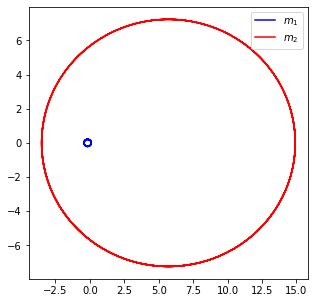

In [492]:
G = 20.
m1 = 35.
m2 = 1.


orbit1 = Cartesian_Orbit(m1,m2,G)
x1_0, x1_dot_0 =0.1, 0.
y1_0, y1_dot_0 = 0., 0.5
x2_0, x2_dot_0 = -(m1/m2) * x1_0,-(m1/m2) * x1_dot_0
y2_0, y2_dot_0 = -(m1/m2) * y1_0, -(m1/m2) * y1_dot_0

f_0 = [x1_0, x1_dot_0, y1_0, y1_dot_0, x2_0, x2_dot_0, y2_0, y2_dot_0]
x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot = orbit1.solve_ode(t_pts,f_0)


fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
start,stop = start_stop_indices(t_pts,t_start,t_end)
ax.plot(x1, y1, color = 'blue', label = r'$m_1$')
ax.plot(x2, y2, color = 'red', label = r'$m_2$')
ax.set_label('Gravitational Orbit3')
ax.legend()

# Now to animate an example of this orbits

In [502]:
from matplotlib import animation, rc
from IPython.display import HTML

In [530]:
%%capture
t_start = 0.
t_end = 50.
delta_t = 0.01
t_pts = np.arange(t_start, t_end + delta_t, delta_t)

G = 10.
m1 = 1.
m2 = 1.

orbit2 = Cartesian_Orbit(m1,m2,G)
x1_0, x1_dot_0 =1., 0.
y1_0, y1_dot_0 = 0., 1.
x2_0, x2_dot_0 = -(m1/m2) * x1_0,-(m1/m2) * x1_dot_0
y2_0, y2_dot_0 = -(m1/m2) * y1_0, -(m1/m2) * y1_dot_0

f_0 = [x1_0, x1_dot_0, y1_0, y1_dot_0, x2_0, x2_dot_0, y2_0, y2_dot_0]
x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot = orbit2.solve_ode(t_pts,f_0)

fig_anim = plt.figure(figsize=(5,5), num='2 Body Orbit')

ax_anim = fig_anim.add_subplot(1,1,1)
ax_anim.set_xlim(-1.5, 1.5)
ax_anim.set_ylim(-1.5, 1.5)

orbit_path1, = ax_anim.plot(x1,y1, color = 'blue', lw =1)
orbit_path2, = ax_anim.plot(x2,y2, color = 'red', lw =1)

planet1, = ax_anim.plot(x1[0], y1[0], color = 'blue', markersize = 10, marker = 'o')
planet2, = ax_anim.plot(x2[0], y2[0], color = 'red', markersize = 10, marker = 'o')


In [522]:
def animate_Orbit(i):
    """This is the function called by FuncAnimation to create each frame,
        numbered by i.  So each i corresponds to a point in the t_pts
        array, with index i.
    """
    orbit_path1.set_data(x1,y1,)
    orbit_path2.set_data(x2,y2,)
    planet1.set_data(x1[i],y1[i])
    planet2.set_data(x2[i],y2[i])
    
    return (orbit_path1, orbit_path2, planet1, planet2)

In [496]:
frame_interval = 30.  # time between frames
frame_number = 500    # number of frames to include (index of t_pts)
anim = animation.FuncAnimation(fig_anim, 
                               animate_Orbit, 
                               init_func=None,
                               frames=frame_number, 
                               interval=frame_interval, 
                               blit=True,
                               repeat=False)

In [503]:
HTML(anim.to_jshtml())

In [531]:
x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot = orbit2.solve_ode(t_pts, f_0)
x1a, x1a_dot, y1a, y1a_dot, x2a, x2a_dot, y2a, y2a_dot = orbit2.solve_ode_Leapfrog(t_pts, f_0)

In [532]:
E_tot_pts = orbit2.energy(t_pts, x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot)
E_tot_0 = E_tot_pts[0]
E_tot_rel_pts = np.abs((E_tot_pts - E_tot_0)/E_tot_0)

E_tot_pts_LF = orbit2.energy(t_pts, x1a, x1a_dot, y1a, y1a_dot, x2a, x2a_dot, y2a, y2a_dot)
E_tot_0_LF = E_tot_pts_LF[0]
E_tot_rel_pts_LF = np.abs((E_tot_pts_LF - E_tot_0_LF)/E_tot_0_LF)

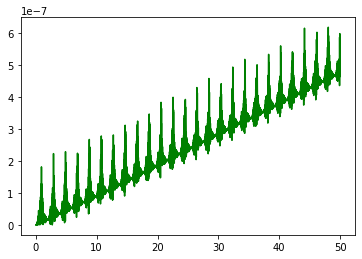

In [537]:
plt.plot(t_pts, E_tot_rel_pts, color='green', label=r'$\Delta E(t)$ RK45')
#plt.plot(t_pts, E_tot_rel_pts_LF,color='red', label=r'$\Delta E(t)$ Leapfrog')
#plt.xlim(0,10)
#plt.ylim(-.00001,1000)

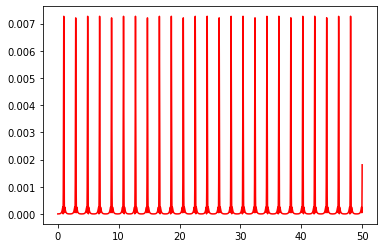

In [540]:
plt.plot(t_pts, E_tot_rel_pts_LF,color='red', label=r'$\Delta E(t)$ Leapfrog')